<h3> Importy

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from random import randint

<h3>Wczytanie i przygotowanie danych

In [2]:
def load_and_prepare_data(vocab_size, max_len):
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

    x_train = pad_sequences(x_train, maxlen=max_len, padding="post", truncating="post")
    x_test = pad_sequences(x_test, maxlen=max_len, padding="post", truncating="post")

    x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
    x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

    return x_train, y_train, x_test, y_test

def create_dataloader(x_train, y_train, batch_size):
    train_data = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader

<h3>Budowa modelu

In [3]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim, rnn_type, hidden_dim = 128, output_dim = 1, batch_size = 64):
        super(SentimentRNN, self).__init__()
        self.rnn_type = rnn_type
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.embedding = nn.Embedding(vocab_size, self.embed_dim)   # embedding slów
        self.fc = nn.Linear(hidden_dim, output_dim)                 # wartswa liniowa
        self.activation = nn.Sigmoid()                              # funkcja aktywacji

        if self.rnn_type == "LSTM":                                 # warstwa rekurencyjna
            self.rnn = nn.LSTM(self.embed_dim, hidden_dim, batch_first=True)
        elif self.rnn_type == "RNN":
            self.rnn = nn.RNN(self.embed_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type. Choose 'LSTM' or 'RNN'.")
        
        self.x_train, self.y_train, self.x_test, self.y_test = load_and_prepare_data(vocab_size, self.max_len)
        self.train_loader = create_dataloader(self.x_train, self.y_train, batch_size)

    # RNN zwraca tylko dwa elementy: sekwencję wyjść i ostatni stan ukryty. W przypadku RNN nie występuje dodatkowy cel ukryty, jak w LSTM
    def forward(self, x):
        x = self.embedding(x)
        if self.rnn_type == "LSTM": _, (hidden, _) = self.rnn(x)
        elif self.rnn_type == "RNN": _, hidden = self.rnn(x)
        else: raise ValueError("Unknown RNN type in forward method. Choose 'LSTM' or 'RNN'.")
        x = self.fc(hidden[-1])
        return self.activation(x)  # Funkcja aktywacji (sigmoid)

<h3>Implementacja funkcji treningu i ewaluacji

In [4]:
def train_model(model, results, criterion = nn.BCELoss(), epochs = 10, learning_rate = 0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    len_model = len(model.train_loader)
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in model.train_loader:
            optimizer.zero_grad()
            predictions = model(x_batch).squeeze()
            loss = criterion(predictions, y_batch.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        acc = evaluate_model(model, model.x_test, model.y_test)
        print(f"Model {model.rnn_type}, epoch {epoch + 1}, Loss: {total_loss / len_model * 100:.2f}%, Acc: {acc * 100:.2f}%")
        if (model.rnn_type, model.embed_dim, model.max_len) in results:
            results[(model.rnn_type, model.embed_dim, model.max_len)].append((total_loss / len_model, acc))
        else:
            results[(model.rnn_type, model.embed_dim, model.max_len)] = [(total_loss / len_model, acc)]

def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).squeeze()
        predictions = torch.round(predictions)
        accuracy = (predictions == y_test).float().mean().item()
    return accuracy

<h3>Trening i ocena modelu

In [5]:
vocab_size = 2000  # Liczba najczęściej występujących słów

results = {}

models = [
        # Modele standardowe
        SentimentRNN(vocab_size, 50, 32, "LSTM"),
        SentimentRNN(vocab_size, 50, 32, "RNN"),

        # Zmienona długość recenzji
        SentimentRNN(vocab_size, 20, 32, "LSTM"),
        SentimentRNN(vocab_size, 20, 32, "RNN"),
        SentimentRNN(vocab_size, 100, 32, "LSTM"),
        SentimentRNN(vocab_size, 100, 32, "RNN"),
        SentimentRNN(vocab_size, 10, 32, "LSTM"),
        SentimentRNN(vocab_size, 10, 32, "RNN"),
        SentimentRNN(vocab_size, 200, 32, "LSTM"),
        SentimentRNN(vocab_size, 200, 32, "RNN"),

        # Zmieniona wielkość warstwy rekurencyjnej
        SentimentRNN(vocab_size, 50, 64, "LSTM"),
        SentimentRNN(vocab_size, 50, 64, "RNN"),
        SentimentRNN(vocab_size, 50, 128, "LSTM"),
        SentimentRNN(vocab_size, 50, 128, "RNN"),
        SentimentRNN(vocab_size, 50, 8, "LSTM"),
        SentimentRNN(vocab_size, 50, 8, "RNN"),
        SentimentRNN(vocab_size, 50, 16, "LSTM"),
        SentimentRNN(vocab_size, 50, 16, "RNN"),
        ]

for model in models:
    train_model(model, results)

Model LSTM, epoch 1, Loss: 69.12%, Acc: 56.42%
Model LSTM, epoch 2, Loss: 67.99%, Acc: 57.05%
Model LSTM, epoch 3, Loss: 65.41%, Acc: 63.76%
Model LSTM, epoch 4, Loss: 64.24%, Acc: 66.51%
Model LSTM, epoch 5, Loss: 58.93%, Acc: 69.63%
Model LSTM, epoch 6, Loss: 54.47%, Acc: 71.86%
Model LSTM, epoch 7, Loss: 50.96%, Acc: 73.27%
Model LSTM, epoch 8, Loss: 48.22%, Acc: 73.66%
Model LSTM, epoch 9, Loss: 46.24%, Acc: 74.26%
Model LSTM, epoch 10, Loss: 44.23%, Acc: 74.52%
Model RNN, epoch 1, Loss: 69.54%, Acc: 50.43%
Model RNN, epoch 2, Loss: 69.27%, Acc: 52.19%
Model RNN, epoch 3, Loss: 68.75%, Acc: 54.00%
Model RNN, epoch 4, Loss: 67.44%, Acc: 56.68%
Model RNN, epoch 5, Loss: 66.28%, Acc: 54.01%
Model RNN, epoch 6, Loss: 64.06%, Acc: 64.54%
Model RNN, epoch 7, Loss: 65.68%, Acc: 57.49%
Model RNN, epoch 8, Loss: 63.12%, Acc: 56.81%
Model RNN, epoch 9, Loss: 65.88%, Acc: 56.16%
Model RNN, epoch 10, Loss: 65.67%, Acc: 66.09%
Model LSTM, epoch 1, Loss: 67.89%, Acc: 60.50%
Model LSTM, epoch 2, 

<h3>Wizualizacja wyników

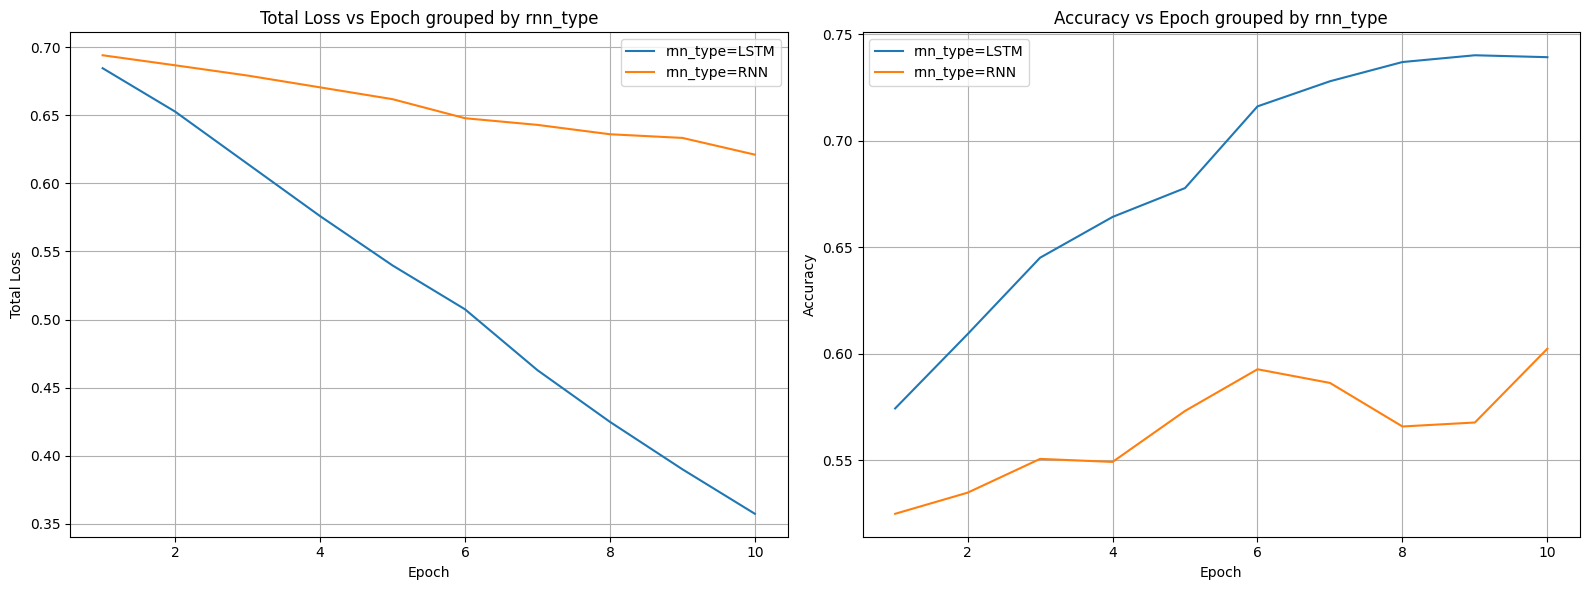

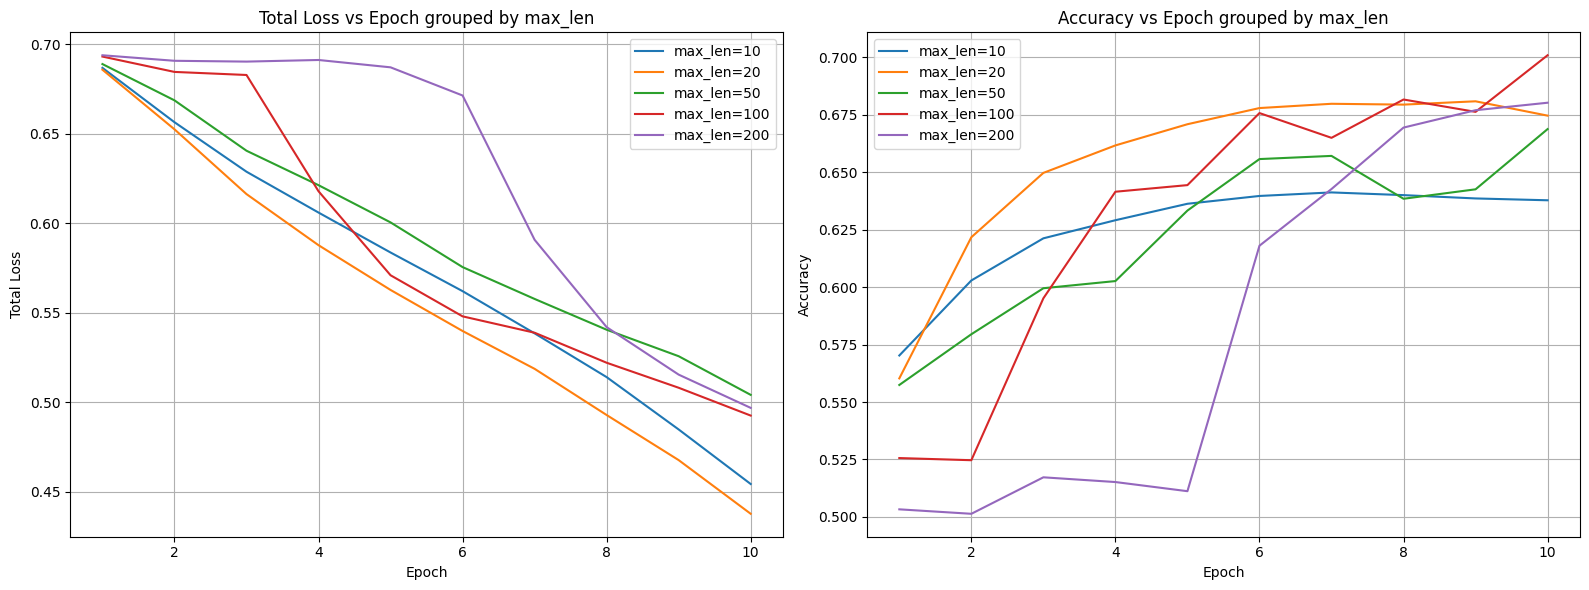

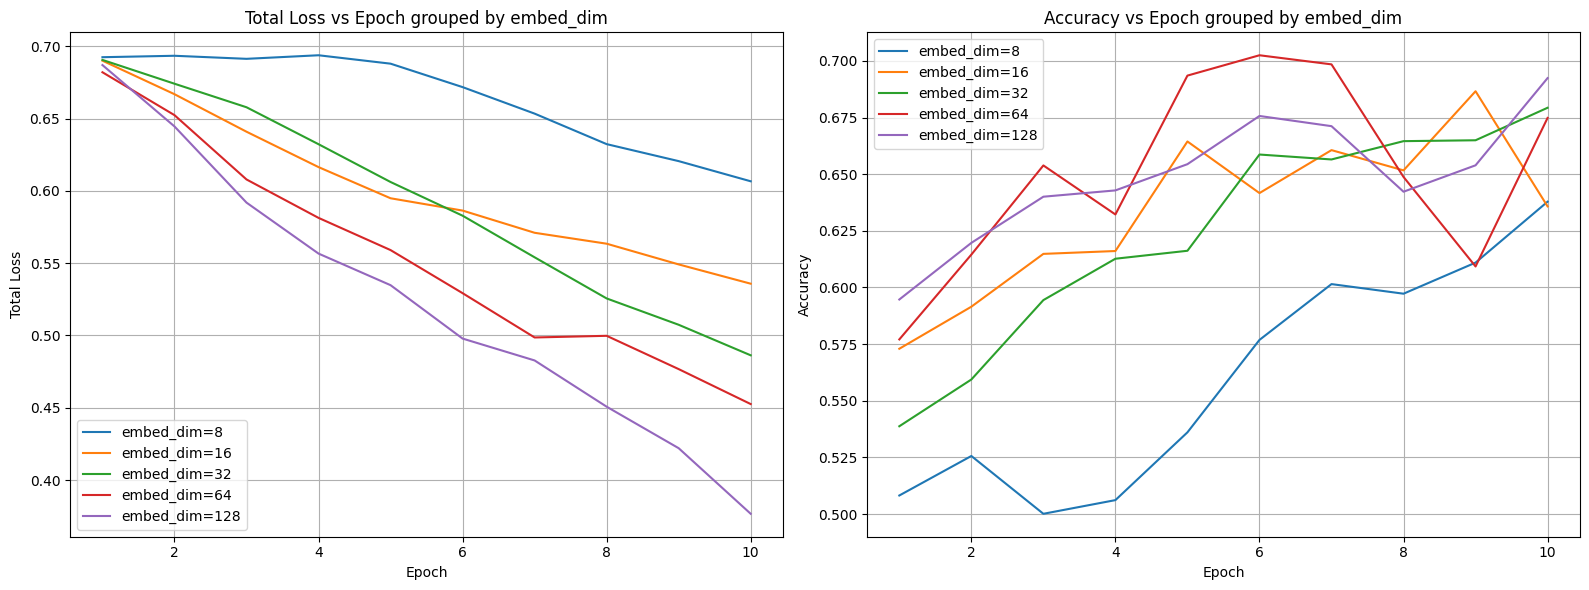

In [10]:
import matplotlib.pyplot as plt

max_lens = sorted(set(key[2] for key in results.keys()))
embed_dims = sorted(set(key[1] for key in results.keys()))
rnn_types = sorted(set(key[0] for key in results.keys()))

data_by_rnn_type = {rnn_type: [] for rnn_type in rnn_types}
for (rnn_type, embed_dim, max_len), metrics in results.items():
    data_by_rnn_type[rnn_type].append(metrics)

data_by_max_len = {max_len: [] for max_len in max_lens}
for (rnn_type, embed_dim, max_len), metrics in results.items():
    data_by_max_len[max_len].append(metrics)

data_by_embed_dim = {embed_dim: [] for embed_dim in embed_dims}
for (rnn_type, embed_dim, max_len), metrics in results.items():
    data_by_embed_dim[embed_dim].append(metrics)

def plot_results_side_by_side(data, group_by):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    for ax, metric_name, idx in zip(axes, ["Total Loss", "Accuracy"], [0, 1]):
        for group, group_data in data.items():
            avg_metric = [sum(epoch[idx] for epoch in batch) / len(batch) for batch in zip(*group_data)]
            ax.plot(range(1, len(avg_metric) + 1), avg_metric, label=f"{group_by}={group}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric_name)
        ax.set_title(f"{metric_name} vs Epoch grouped by {group_by}")
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

plot_results_side_by_side(data_by_rnn_type, "rnn_type")
plot_results_side_by_side(data_by_max_len, "max_len")
plot_results_side_by_side(data_by_embed_dim, "embed_dim")

<h3> <b>Wnioski</b> </br>
- <b>Rodzaj modelu</b>: Model LSTM wykazuje się lepszymi wartościami wyników od modelu RNN</br>
- <b>Maksymalna długość recenzji</b>: Przy wystarczającej ilości epok modele wykorzystujące dłuższe recenzje poradziły sobie lepiej od modeli z recenzjami krótkimi </br>
- <b>Wielkość warstwy rekurencyjnej</b>: Im większa warstwa rekurencyjna, tym lepsze wyniki osiąga model </br>